# Preparação dos Microdados do ENEM
Este notebook faz um processamento inicial dos microdados do ENEM e guarda dados processados no diretório `data`, que deve existir. É preciso:
* fazer [download dos microdados do INEP](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem) e colocar num diretório `../inep/enem/{ano}`.
* nos diretórios `../inep/enem/{ano}/DADOS/`, converter os dados dos itens `ITENS_XXX.csv` para utf8 (usando `iconv -f iso-8859-1 -t utf-8 ITENS_PROVA_2023.csv > ITENS_PROVA_2023-utf8.csv`, veja mais [receitas aqui](https://github.com/atp/enem/wiki).
 


In [3]:
import numpy as np
import pandas as pd
import random
import seaborn as sns

%load_ext autoreload
%autoreload 2

import warnings
#warnings.filterwarnings("ignore")

In [4]:
print("numpy: ",np.__version__)
print("pandas: ", pd.__version__)

numpy:  2.1.1
pandas:  2.2.2


# Ler microdados do ENEM

## Selecionar apenas uma amostra aleatória de 1% dos alunos
Se a gente lê o arquivo de 3GB inteiro, vai dar problema. Aqui tem uma receita para ler somente x%: https://www.kaggle.com/questions-and-answers/53925 

In [10]:
def skip(i,fraction=0.01):
    if i == 0:
        return False  # precisamos manter o row=0 para ter o header
    else:
        return random.random() > fraction

[skip(i) for i in range(10)]

[False, True, True, True, True, True, True, True, True, True]

A título de exemplo, vamos carregar os dados de 2010.

In [11]:
%time df = pd.read_csv('../inep/enem/2010/DADOS/MICRODADOS_ENEM_2010.csv',skiprows = skip, encoding='latin1',sep=";")

CPU times: user 19.4 s, sys: 2.67 s, total: 22.1 s
Wall time: 38.6 s


In [18]:
df.sample()

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ST_CONCLUSAO,TP_ENSINO,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,...,Q070,Q071,Q072,Q073,Q074,Q075,TP_NACIONALIDADE,ANO_CONCLUIU,Q076,IN_TREINEIRO
6518,300000942223,2011,6,M,1.0,1.0,NaN,NaN,NaN,NaN,...,A,A,D,D,D,A,NaN,NaN,NaN,NaN


In [17]:
for col in df.columns:
    print(col)

NU_INSCRICAO
NU_ANO
TP_FAIXA_ETARIA
TP_SEXO
TP_ST_CONCLUSAO
TP_ENSINO
CO_MUNICIPIO_ESC
NO_MUNICIPIO_ESC
CO_UF_ESC
SG_UF_ESC
TP_DEPENDENCIA_ADM_ESC
TP_LOCALIZACAO_ESC
TP_SIT_FUNC_ESC
CO_MUNICIPIO_PROVA
NO_MUNICIPIO_PROVA
CO_UF_PROVA
SG_UF_PROVA
TP_PRESENCA_CN
TP_PRESENCA_CH
TP_PRESENCA_LC
TP_PRESENCA_MT
NU_NOTA_CN
NU_NOTA_CH
NU_NOTA_LC
NU_NOTA_MT
TX_RESPOSTAS_CN
TX_RESPOSTAS_CH
TX_RESPOSTAS_LC
TX_RESPOSTAS_MT
CO_PROVA_CN
CO_PROVA_CH
CO_PROVA_LC
CO_PROVA_MT
TX_GABARITO_CN
TX_GABARITO_CH
TX_GABARITO_LC
TX_GABARITO_MT
TP_STATUS_REDACAO
NU_NOTA_COMP1
NU_NOTA_COMP2
NU_NOTA_COMP3
NU_NOTA_COMP4
NU_NOTA_COMP5
NU_NOTA_REDACAO
IN_CERTIFICADO
IN_QSE
Q1
Q2
Q3
Q4
Q5
Q6
Q7
Q8
Q9
Q10
Q11
Q12
Q13
Q14
Q15
Q16
Q17
Q18
Q19
Q20
Q21
Q22
Q23
Q24
Q25
Q26
Q27
Q28
Q29
Q30
Q31
Q32
Q33
Q34
Q35
Q36
Q37
Q38
Q39
Q40
Q41
Q42
Q43
Q44
Q45
Q46
Q47
Q48
Q49
Q50
Q51
Q52
Q53
Q54
Q55
Q56
Q57
Q58
Q59
Q60
Q61
Q62
Q63
Q64
Q65
Q66
Q67
Q68
Q69
Q70
Q71
Q72
Q73
Q74
Q75
Q76
Q77
Q78
Q79
Q80
Q81
Q82
Q83
Q84
Q85
Q86
Q87
Q88
Q89
Q90
Q91

De fato, só vem 50 mil linhas (os dados originais devem conter da ordem de 3-6 milhões de participantes)

Em seguinda, vamos filtrar estes dados pela presença na prova, se é treineiro e estar concluindo o EM.

In [13]:
df["TP_PRESENCA_CN"].value_counts(dropna=False)

TP_PRESENCA_CN
1    34036
0    12175
2       64
Name: count, dtype: int64

In [14]:
df['TP_ST_CONCLUSAO'].value_counts(dropna=False)

TP_ST_CONCLUSAO
1    27174
2    13682
3     5419
Name: count, dtype: int64

In [15]:
df["TP_ESTADO_CIVIL"].value_counts(dropna=False)

TP_ESTADO_CIVIL
0    37745
1     7446
2      945
3      139
Name: count, dtype: int64

## Filtrar os dados por presença, treineiro, EM e notas não-zero

In [16]:
def filterdf(df):
    df = df[df["TP_PRESENCA_CN"] == 1]  # presente nas 4 provas
    df = df[df["TP_PRESENCA_CH"] == 1]
    df = df[df["TP_PRESENCA_LC"] == 1]
    df = df[df["TP_PRESENCA_MT"] == 1]
    if "IN_TREINEIRO" in df.columns:
        df = df[(df["IN_TREINEIRO"] == 0) | (df["IN_TREINEIRO"].isna())]  # não é treineiro ou não existe 
    df = df[df["TP_ST_CONCLUSAO"].isin([1, 2])]  # afirma que concluiu EM ou que vai concluir EM no ano da aplicação
    # não queremos as notas == 0
    df = df.query("NU_NOTA_CH != 0 and NU_NOTA_CN != 0 and NU_NOTA_LC != 0 and NU_NOTA_MT != 0")
    df.dropna(subset = ['TX_RESPOSTAS_CN','TX_RESPOSTAS_CH','TX_RESPOSTAS_LC','TX_RESPOSTAS_MT']) # achamos linhas com NaN para estas colunas!
    # achamos gabaritos com '---------------------------------------------'
    for area in ['CN','CH','LC','MT']:
        df = df[df['TX_GABARITO_'+area] !='---------------------------------------------']
    return df


def load_data(ano,frac,orig=False):
    'carrega dados com determinado ano e fração'
    print(f"processando {ano} com fraçao = {frac*100:.0f}%",ano, frac)
    def skip(i,fraction=frac):
        if i == 0:
            return False  # precisamos manter o row=0 para ter o header
        else:
            return random.random() > fraction
   
    if ano == 2016:
        caminho = f'../inep/enem/{ano}/DADOS/microdados_enem_{ano}.csv'
    else:
        caminho = f'../inep/enem/{ano}/DADOS/MICRODADOS_ENEM_{ano}.csv'
    if orig:
        caminho = f'../inep/enem/orig/{ano}/DADOS/MICRODADOS_ENEM_{ano}.csv'
        if ano == 2016:
            caminho = f'../inep/enem/orig/{ano}/DADOS/microdados_enem_{ano}.csv'
            
    print(caminho)
    df = pd.read_csv(caminho,skiprows = skip, encoding='latin1',sep=";")
    return df
    
def filter_data(df):
    print("filter data...")
    return filterdf(df)

def nome_do_arquivo(ano,frac):
    frac = frac*100
    fn = f'data/enem_{frac:.0f}_{ano}.csv'
    return fn

df = load_data(2023,0.01)
print(len(df))
df = filter_data(df)
print(len(df))

processando 2023 com fraçao = 1% 2023 0.01
../inep/enem/2023/DADOS/MICRODADOS_ENEM_2023.csv
39497
filter data...
21360


In [17]:
df['TX_RESPOSTAS_LC'][:10]

0     BEDCEBBAADDCECECACBBBBDECDBDAAEECBCEDCACEDBBE
2     BDDBBAEAAEBCCDBAEDDEDABACBDCAACDAAAACADCBEAAE
3     ECBBAAAEDBBEAEDCABDEAECBACCCEDDBBDCDBAEADACCE
4     CABBDAACBBEEBADABABEADBAACCEEADAACCBBEDBDAADD
6     CCAABDECAEBACDBADCDDDCACBCACEACBBEAEEADDBEBAE
7     DBEEEBECACACBABDEAAEDAAEDACCBDCCBEAEEABEBECAE
9     AEABEAAABCEDAACAAEBAADBBCBAAEACBECAAAACCCAAEC
10    ABEBADBDDEDC.DBADEDEACDEDBACAA.BBCED.A.CBEAAB
11    EACCCABBABBDEBAAEABBDECCDBECCBEAABBCBEAAACABD
12    CECEAAAAAEDCCDBBDAAAACBEADACAACBCBBCCAABBDCAA
Name: TX_RESPOSTAS_LC, dtype: object

In [18]:
df.columns

Index(['NU_INSCRICAO', 'NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
       'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC',
       'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC',
       'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA',
       'SG_UF_PROVA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'TP_PRESENCA_MT', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC',
       'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC',
       'TX_RESPOSTAS_MT', 'TP_LINGUA', 'TX_GABARITO_CN', 'TX_GABARITO_CH',
       'TX_GABARITO_LC', 'TX_GABARITO_MT', 'TP_STATUS_REDACAO',
       'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004',

In [19]:
df['TP_ANO_CONCLUIU'].describe()

count    21360.000000
mean         2.373315
std          4.289149
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         17.000000
Name: TP_ANO_CONCLUIU, dtype: float64

## Aqui faremos o trabalho de verdade
Isso deve levar alguns minutos.

In [20]:
frac = 0.01
for ano in range(2009,2024):
    df = load_data(ano,frac)
    df = filter_data(df)
    fn = nome_do_arquivo(ano,frac)
    #print(fn+"...\n")
    df.to_csv(fn,index=False)

import inspect
filter_conditions = inspect.getsource(filterdf)
with open('data/filters.txt','w') as f:
    f.write(filter_conditions)

processando 2009 com fraçao = 1% 2009 0.01
../inep/enem/2009/DADOS/MICRODADOS_ENEM_2009.csv
filter data...
processando 2010 com fraçao = 1% 2010 0.01
../inep/enem/2010/DADOS/MICRODADOS_ENEM_2010.csv
filter data...
processando 2011 com fraçao = 1% 2011 0.01
../inep/enem/2011/DADOS/MICRODADOS_ENEM_2011.csv
filter data...
processando 2012 com fraçao = 1% 2012 0.01
../inep/enem/2012/DADOS/MICRODADOS_ENEM_2012.csv
filter data...
processando 2013 com fraçao = 1% 2013 0.01
../inep/enem/2013/DADOS/MICRODADOS_ENEM_2013.csv
filter data...
processando 2014 com fraçao = 1% 2014 0.01
../inep/enem/2014/DADOS/MICRODADOS_ENEM_2014.csv
filter data...
processando 2015 com fraçao = 1% 2015 0.01
../inep/enem/2015/DADOS/MICRODADOS_ENEM_2015.csv
filter data...
processando 2016 com fraçao = 1% 2016 0.01
../inep/enem/2016/DADOS/microdados_enem_2016.csv
filter data...
processando 2017 com fraçao = 1% 2017 0.01
../inep/enem/2017/DADOS/MICRODADOS_ENEM_2017.csv
filter data...
processando 2018 com fraçao = 1% 2018

### Demonstração
Para demonstrar o que podemos fazer com os arquivos gerados:

In [8]:
from util import load_sample
df = load_sample(2011,n=500,perc=1) # uma amostra de 500 linhas, por sua vez, da nossa amostra de 1%
df

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,Q066,Q067,Q068,Q069,Q070,Q071,Q072,Q073,Q074,Q075
3125,300000455873,2011,2,M,1,0,2,8,1,1.0,...,A,D,A,A,A,A,A,A,D,A
15627,300002335476,2011,2,M,1,1,2,0,1,2.0,...,A,A,A,A,C,A,A,A,A,C
21664,300003305614,2011,2,M,1,0,2,2,1,1.0,...,A,A,A,A,A,A,A,A,A,B
16680,300002498197,2011,5,M,1,3,1,0,2,1.0,...,D,A,A,D,A,A,D,D,D,A
27223,300004277534,2011,4,F,1,3,1,3,1,1.0,...,A,A,A,D,B,D,D,D,D,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26728,300004178541,2011,2,M,1,3,2,2,1,1.0,...,A,A,D,A,C,A,D,D,D,A
11050,300001602493,2011,2,F,1,1,2,8,1,1.0,...,B,A,A,A,C,A,D,D,D,C
49,300000009177,2011,13,M,2,0,1,0,2,1.0,...,D,A,D,A,A,A,D,D,D,A
1043,300000155807,2011,2,F,1,1,2,0,1,1.0,...,A,A,A,A,B,A,D,D,A,B


<Axes: xlabel='NU_NOTA_CH', ylabel='Count'>

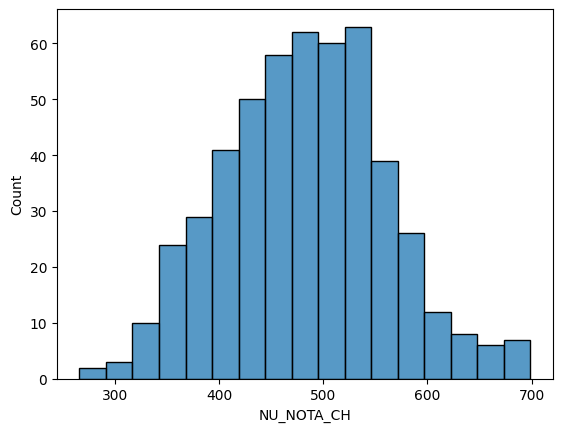

In [10]:
sns.histplot(df,x='NU_NOTA_CH')

In [11]:
l = []
for ano in range(2009,2024):
    l.append(load_sample(ano,1000))
df = pd.concat(l)

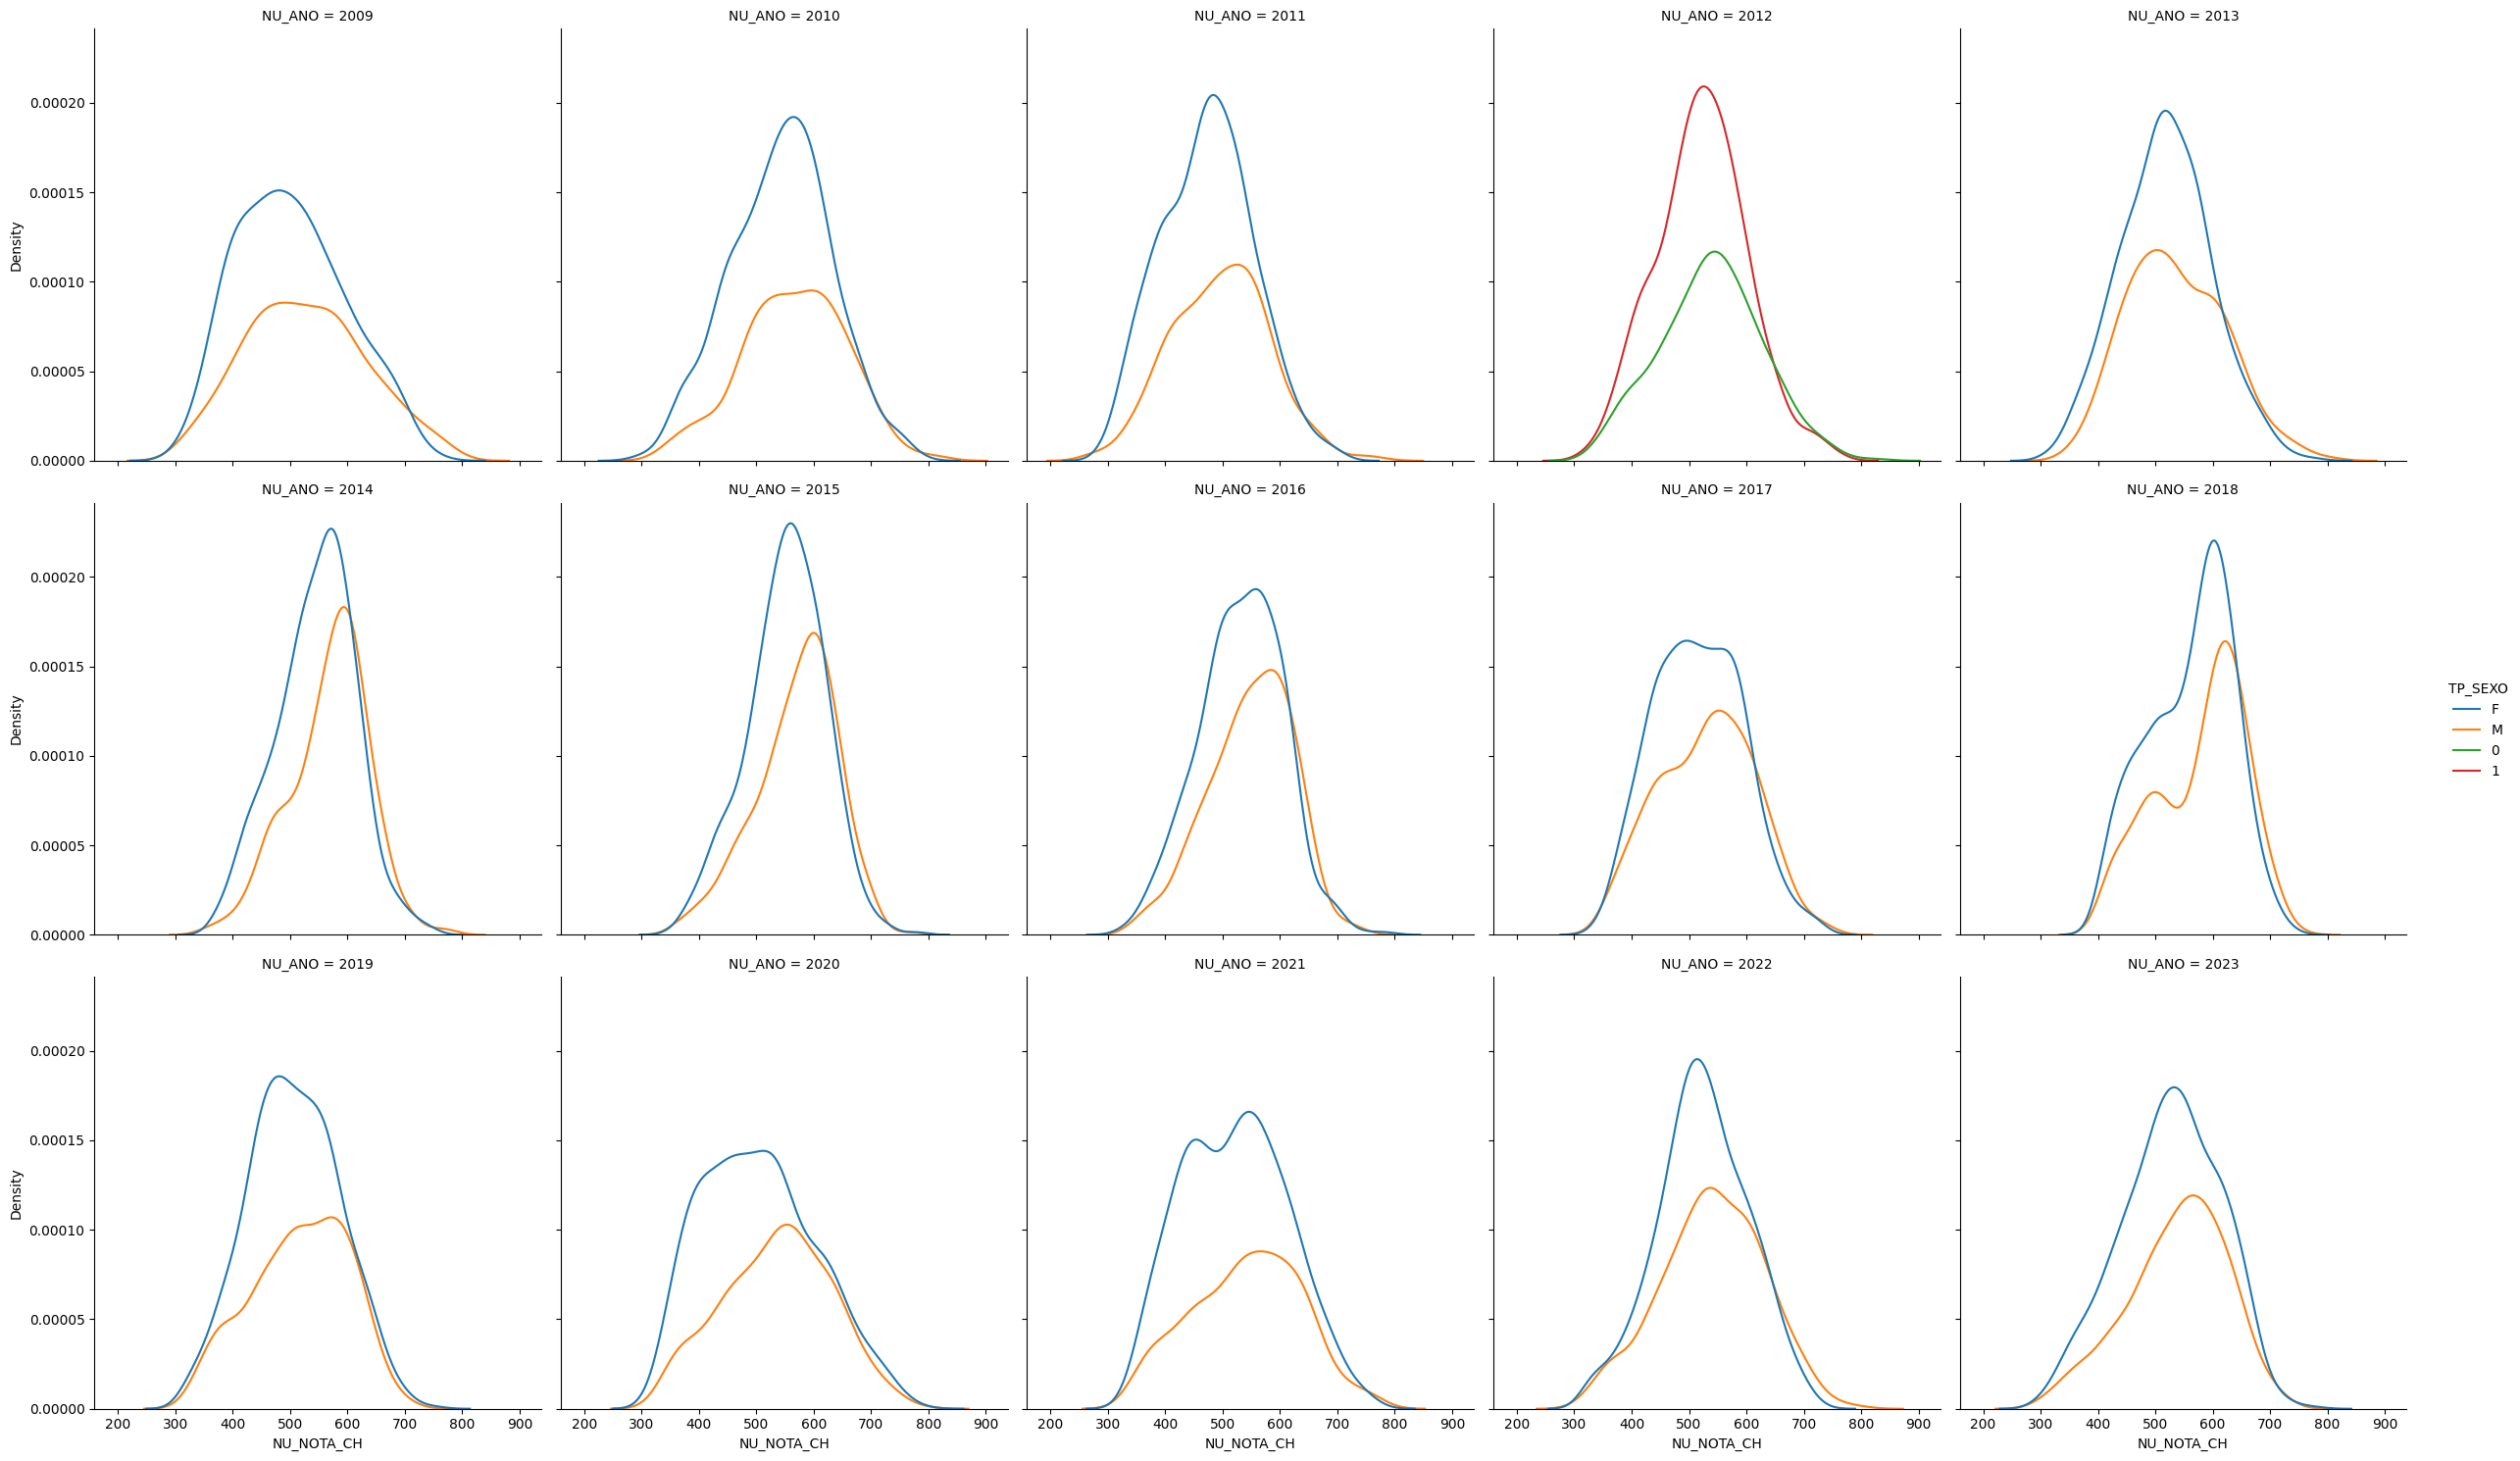

In [12]:
sns.displot(df,x='NU_NOTA_CH',kind='kde',hue='TP_SEXO',col='NU_ANO',col_wrap=5)

# Informação dos itens

Abaixo carregamos todas as planilhas com informações sobre os itens do ENEM disponibilizadas pelo INEP. Assumimos que as planilhas já foram convertidas para utf8. Em 2009 houve alguns itens sem CO_ITEM. Parece interessante de carregar estes dados sempre usando `dtype={'CO_ITEM':str}`, para que o pandas não interpreta o número como `float`. Vamos guardar estes informações sobre os itens fornecidos pelo INEP em `data/itens_inep.csv`

## Planilha com todos os dados do INEP
Por incrível que pareça, a cor AMARELO/A não é padronizado entre anos, nem a capitalização.



In [29]:
def padronizar_amarelo(s):
    if s == 'AMARELO':
        return 'AMARELA'
    else:
        return s

df = pd.DataFrame()
for ano in range(2009,2024):
    item_info = pd.read_csv(f'../dados/enem/{ano}/DADOS/ITENS_PROVA_{ano}-utf8.csv',sep='\;',
                        engine='python',dtype={'CO_ITEM':str})
    item_info['ano'] = ano
    item_info['TX_COR'] = item_info['TX_COR'].str.upper().str.strip()
    item_info['TX_COR'] = item_info['TX_COR'].apply(padronizar_amarelo)
    df = pd.concat([df,item_info])
    
df.to_csv('data/itens_inep.csv',index=False)

### Demonstração
Agora é simples usar as informções sobre os itens dado pelo INEP (vamos usar em particular os parâmetros TRI dos itens)

In [13]:
from util import item_info_inep
item_info_inep(2011,'CH')

,CO_POSICAO,SG_AREA,CO_ITEM,TX_GABARITO,CO_HABILIDADE,IN_ITEM_ABAN,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,ano,TP_LINGUA,IN_ITEM_ADAPTADO,TP_VERSAO_DIGITAL
3032,2,CH,70264,E,22.0,0,NaN,1.60553,0.33263,0.09496,BRANCO,134,2011,NaN,NaN,NaN
3075,29,CH,70452,A,21.0,0,NaN,2.06152,0.49627,0.15444,BRANCO,134,2011,NaN,NaN,NaN
3080,20,CH,70475,C,13.0,0,NaN,0.94594,2.61392,0.19809,BRANCO,134,2011,NaN,NaN,NaN
3086,19,CH,70514,A,15.0,0,NaN,2.36969,-0.02116,0.09568,BRANCO,134,2011,NaN,NaN,NaN
3087,17,CH,70524,C,6.0,0,NaN,2.01158,1.72406,0.16014,BRANCO,134,2011,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,15,CH,75706,C,7.0,0,NaN,1.25147,-0.22962,0.22347,AZUL,117,2011,NaN,NaN,NaN
3771,10,CH,75717,A,26.0,0,NaN,1.97592,0.03668,0.24629,ROSA,120,2011,NaN,NaN,NaN
3772,11,CH,75717,A,26.0,0,NaN,1.97592,0.03668,0.24629,AMARELA,118,2011,NaN,NaN,NaN
3773,12,CH,75717,A,26.0,0,NaN,1.97592,0.03668,0.24629,AZUL,117,2011,NaN,NaN,NaN


# Preparar os dados para análise TRI
Precisamos converter as respostas e o gabarito no microdados do INEP para um formato que os pacotes de TRI conseguem ler.

## Funções para extrair acertos
A maioria das análises TRI vão precisar de uma "dicomitização" das respostas. A estrutura de dados que vamos precisar é uma matriz com colunas itens e linhas pessoas com valores 0 e 1 para erros e acertos respectivamente.

Vamos tentar criar umas funções que crie este estrutura de dados. Temos algumas informações sobre a estrutura dos microdados:
* Vamos ter que levar em conta as primeiras 5 itens da prova LC (Linguágens e Códigos). Desde 2010 estas posições são usadas para as questões de língua estrangeira (espanhol ou inglês). É possível, mas não tenho certeza, que somente 40 questões de LC são usados para criar a escala IRT desta prova.
* O INEP divulga os parámetros IRT (veja acima). Além disso, dizem quais itens foram eliminados ("pelo IRT"), porque aparentemente atrapalharam a convergência da estimação do modelo IRT 3PL que estão usando. Vamos identificar estes itens, para poder decidir na hora da análise se incluir ou não.

In [33]:
from util import load_sample, item_info_inep


In [136]:
# Um monte de gambiarra, mas o resultado final deve ser a conversão dos microdados originais, com colunas do tipo
# "ABBCABE..." para as respostas e gabaritos, para dataframes com colunas (com nomes do itens dados pelo INEP) e linhas
# do tipo 0,1,0,0,1... para acertos e erros.

# Um maior chatice é tratar LC, que tem um jeito particularmente inconveniente de guardar se o aluno fez 5 questões de inglês
# ou de espanhol no início da prova. 

def to_acertos(s):
    'resp e gab são strings, retorna uma lista'
    resp = s.iloc[0]
    gab = s.iloc[1]
    return [r == g for r,g in zip(resp,gab)]

def to_acertos_lc(s):
    'resp e gab são strings, retorna uma lista'
    lang = s.iloc[2]
    if lang == 0: #ingles
        gab = s.iloc[1][:5] + s.iloc[1][10:]
    else:
        gab = s.iloc[1][5:]
    resp = s.iloc[0]
    return [r == g for r,g in zip(resp,gab)]


def acertos_df(df,exame,as_int=True):
    'Retorna dataframe com acertos. Colunas 1-45 = itens, Linhas = idx do df'
    resp_col = 'TX_RESPOSTAS_' + exame
    gab_col = 'TX_GABARITO_' + exame
    ano = df.loc[0,'NU_ANO']
    if exame == 'LC' and ano > 2009:
        lang_col = 'TP_LINGUA'
        adf = df[[resp_col,gab_col,lang_col]].apply(to_acertos_lc,axis=1,result_type = "expand")
        adf['lingua'] = df[lang_col]
    else:
        adf = df[[resp_col,gab_col]].apply(to_acertos,axis=1,result_type = "expand")
    adf['acertos'] = adf.sum(axis=1)
    adf['caderno'] = df.loc[:,"CO_PROVA_" + exame]
    if as_int:
        adf = adf.astype("int")
    adf['nota_inep'] = df.loc[:,"NU_NOTA_" + exame]
    adf['candidato'] = df['NU_INSCRICAO']
    adf = adf.set_index('candidato')
    return adf


def reorder_rename_cols(ac,item_info):
    'takes a df with acertos, cuts it up and renames the columns for each caderno and stitches it back together again.'
    
    groups = []
    cadernos = ac['caderno'].value_counts().index[:4] #only the 4 most used cadernos
    gb = ac.groupby("caderno")
    #cadernos = ac['caderno'].unique()
    for caderno in cadernos:
        #print(caderno)
        itemnames = item_info.query("CO_PROVA == @caderno").sort_values("CO_POSICAO")["CO_ITEM"].values
        
        colmap = {i:j for i,j in zip(ac.columns[:len(itemnames)],itemnames)}
        group = gb.get_group(caderno).rename(colmap,axis=1)
        groups.append(group)
    ac = pd.concat(groups)
    if np.nan in ac.columns:
        ac.drop(columns=np.nan,inplace=True) # itens sem CO_ITEM 
    abandoned_map = {item:f'{item}-aban' for item in item_info.query("IN_ITEM_ABAN == 1").CO_ITEM.unique()}
    ac = ac.rename(columns=abandoned_map)
    return ac

def make_acertos(df,area):
    'Retorna dataframe com acertos. Colunas 1-45 = itens, Linhas = candidatos'
    ano = df.loc[0,'NU_ANO']
    itens = item_info_inep(ano,area)

    if area == 'LC' and ano > 2009:
        ac = acertos_df(df,area)        
        itens_rest = itens.query("TP_LINGUA.isna()")
        ac_rest = reorder_rename_cols(ac.iloc[:,5:],itens_rest)
        ac_rest = ac_rest.drop('lingua',axis=1)
        acs = [ac_rest]
        for lang in [0,1]:
            itens_lang = itens.query("TP_LINGUA == @lang")
            ac_lang = ac.query("lingua == @lang")
            #print(f"ac lang len {lang}: {len(ac_lang)}")
            ac_lang = reorder_rename_cols(ac_lang,itens_lang)
            ac_lang = ac_lang.drop('lingua',axis=1)
            ac_lang = pd.concat([ac_lang.iloc[:,:5],ac_lang.iloc[:,-3:]],axis=1)
            acs.append(ac_lang)
        return acs[0],acs[1],acs[2]
        
    else:
        ac = acertos_df(df,area)
        ac = reorder_rename_cols(ac,itens)
        return ac



In [139]:
perc = 1
for ano in range(2009,2024):
    df = load_sample(ano,perc=perc)
    for area in ['CH', 'CN', 'MT','LC']:
        #print(ano,area)
        if area == 'LC' and ano > 2009:
            ac,ac_en,ac_esp = make_acertos(df,area)
            ac_en.to_csv(f'data/ac_{perc}_{ano}_{area}_en.csv',index=True)
            ac_esp.to_csv(f'data/ac_{perc}_{ano}_{area}_esp.csv',index=True)
            ac.to_csv(f'data/ac_{perc}_{ano}_{area}.csv',index=True)
        else:
            ac = make_acertos(df,area)
            ac.to_csv(f'data/ac_{perc}_{ano}_{area}.csv',index=True)


### Demonstração

In [2]:
from util import load_acertos
ac = load_acertos(2011,'CH')
sns.scatterplot(ac,x='acertos',y='nota_inep')

NameError: name 'sns' is not defined

# Calcular estatísticas TCT dos itens
Usamos a função `mirt::itemstats`. A função item_stats em util.py usa o arquivo itens_inep.csv gerado acima e depende também dos arquivos dos acertos gerados acima.

Também inserimos um URL para as resoluções comentados do Objetivo. Cuidado: não checei exaustivamente todos as gambiaras para chegar no URL certo. No notebook Análise de Itens exemplos de como usar as planilhas geradas pela célula abaixo.

In [141]:
to_rdf(resp)

60123,60124,60125,...,60220,60221,60222
0,1,0,...,0,0,0
1,1,1,,1,1,1
1,0,1,,0,0,0
0,0,0,,0,0,0
...,...,...,,...,...,...
1,0,1,,0,0,0
1,1,1,,1,1,1
1,1,1,,0,0,0
1,1,0,,1,0,0


In [1]:
istats = item_stats(2011,'CH')

NameError: name 'item_stats' is not defined

In [150]:
istats

,N,mean,sd,total.r,url,CO_POSICAO,SG_AREA,TX_GABARITO,CO_HABILIDADE,IN_ITEM_ABAN,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,ano,TP_LINGUA,IN_ITEM_ADAPTADO,TP_VERSAO_DIGITAL
71466,16649,0.294372,0.455774,0.470684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71445,16649,0.303982,0.459989,0.521698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59663,16649,0.773860,0.418343,0.554568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72892,16649,0.739204,0.439082,0.561507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70994,16649,0.188360,0.391011,0.390621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
from util import item_stats
for ano in range(2009,2024):
    for area in ['MT','CH','CN','LC','LC_esp','LC_en']:
        if ano == 2009 and area in ['LC_esp','LC_en']: 
            continue
        istats = item_stats(ano,area)
        istats.to_csv(f'data/istats-{ano}-{area}.csv',index_label='item')

# Calcular notas e parâmetros da escala ENEM
Podemos transformar as padrões de resposta para uma nota de duas formas: usando a função `mirt::fscore` e nossa própria função . Para transformar as notas que estão distribuídas aproximademente $N(0,1)$ para a "Escala ENEM" (que é aproximadamente $N(500,100)$), precisamos dos parâmetros de conversão, que vamos calcular agora. 

In [18]:
from util import provas,load_padr,score_inep
import scipy

Ano 2009 e prova = 50
Ano 2009 e prova = 51
Ano 2009 e prova = 49
Ano 2009 e prova = 52
Ano 2010 e prova = 92
Ano 2010 e prova = 90
Ano 2010 e prova = 89
Ano 2010 e prova = 91
Ano 2011 e prova = 121
skipping prova 121, to be investigated
Ano 2011 e prova = 124
skipping prova 124, to be investigated
Ano 2011 e prova = 122
skipping prova 122, to be investigated
Ano 2011 e prova = 123
skipping prova 123, to be investigated
Ano 2012 e prova = 143
Ano 2012 e prova = 144
Ano 2012 e prova = 141
Ano 2012 e prova = 142
Ano 2013 e prova = 174
Ano 2013 e prova = 171
Ano 2013 e prova = 172
Ano 2013 e prova = 173
Ano 2014 e prova = 199
Ano 2014 e prova = 201
Ano 2014 e prova = 200
Ano 2014 e prova = 202
Ano 2015 e prova = 235
Ano 2015 e prova = 236
Ano 2015 e prova = 237
Ano 2015 e prova = 238
Ano 2016 e prova = 291
Ano 2016 e prova = 292
Ano 2016 e prova = 293
Ano 2016 e prova = 294
Ano 2017 e prova = 392
Standard error of the regression > 0.01 for ano 2017, area CN and prova 392
slope = 125.51177

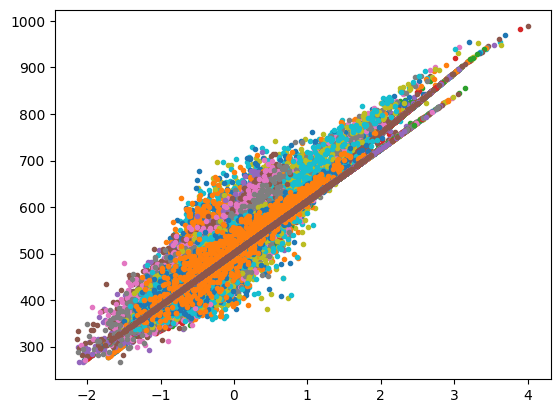

In [44]:
# vamos ter que pular o ano 2011 para a área CN, porque existe um item que não foi marcado como abandonado, 
# mas para qual o INEP não deu os parâmetros IRT
# TODO: investigar se o item foi abandonado (conseguimos reproduzir as notas do INEP sem este item) 
# OU se o item foi usado, mas não sabemos os parâmetros. 
# Estamos com dificuldades de reproduzir exatamente as notas de 2017 e 2018 também. 
# TODO: investigar as razões das discrepâncias para os anos que não conseguimos reproduzir
# TODO: fazer a calibragem para a área LC
results = pd.DataFrame(columns=['ano','area','prova','slope','intercept','stderr'])
for area in ['CN','MT','CH']:
    for ano in range(2009,2024):
        provs = provas(ano,area)
        for prova in provs:
            print(f"Ano {ano} e prova = {prova}")
            padr,notas_inep= load_padr(prova,1000,nota_inep=True)
            if prova in [122,121,123,124]:
                print(f"skipping prova {prova}, to be investigated")
                continue
            notas = score_inep(padr,prova)
            
            x = notas['nota']
            y = notas_inep['nota_inep']
            plt.plot(x,y,'.')
            res = scipy.stats.linregress(x, y)
            if res.stderr > 0.01:
                print(f"Standard error of the regression > 0.01 for ano {ano}, area {area} and prova {prova}")
                print(f"slope = {res.slope}, intercept = {res.intercept}, stderr = {res.stderr}")
            results.loc[len(results)] = [ano,area,prova,res.slope,res.intercept,res.stderr]
    
results['prova'] = results['prova'].astype('int')
results['ano'] = results['ano'].astype('int')    
results.to_csv(f'data/scorecal.csv',index=False)

Uma vez calibrado, podemos agora converter notas e parâmetros dos itens para a escala ENEM

In [56]:
from util import scalecalparams, params_inep, notas_to_enem_scale, irt_params_to_enem_scale

In [14]:
scalecalparams(area='CN')

NameError: name 'scalecalparams' is not defined

In [83]:
params= params_inep(1056)

44

In [87]:
len(irt_params_to_enem_scale(params,1056))

44

In [68]:
padr,nota = load_padr(prova=1058,nota_inep=True)
display(padr,nota)

,44230,67980,75825,82962,83806,87207,88045,95739,95823,96291,...,140721,140914,141030,141048,141072,141148,141322,141355,141364,141384
candidato,,,,,,,,,,,,,,,,,,,,,
210057560956,1,1,0,0,1,0,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0


,acertos,caderno,nota_inep
candidato,,,
210057560956,21,1058,543.9


In [43]:
score_inep(padr,prova=1058,enemscale=True)

,nota,se
candidato,,
210055658956,624.717161,20.53971
